# Imports

In [ ]:
import numpy as np
import pandas as pd

import re
import string
import os

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding,Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.metrics import Precision, Recall
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

!pip install datasets
from datasets import load_dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.0 MB/s eta 0:00:00


# Get and process Dataset
Downloading and loading the dataset from Huggingface. The dataset package is used to get the dataset.

In [ ]:
dataset = load_dataset("mteb/tweet_sentiment_extraction",'en')
dataset['train']

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/mteb___json/mteb--tweet_sentiment_extraction-0669dffec9427684/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 27481
})

In [ ]:
train_data=dataset['train']
test_data=dataset['test']

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_data = train_data.shuffle(BUFFER_SIZE)
test_data = test_data.shuffle(BUFFER_SIZE)

In [ ]:
train_data_df=pd.DataFrame(train_data)
test_data_df=pd.DataFrame(test_data)

In [ ]:
train_data_df.head()

id                                               text  label  \
0  ce1f6366d9                       hahahahaha, I have a day off      2   
1  cb73f98aa9      watching the office......... also comedy gold      1   
2  923295751d  I think my bicycle and I just freaked out a cu...      0   
3  9499e34212   How cool is that!   Thank you so much!   luv it!      2   
4  b39e02ae64         well then happy mothers day  ahahahahahaha      2   

  label_text  
0   positive  
1    neutral  
2   negative  
3   positive  
4   positive

#### Drop unused columns

In [ ]:
df_train=train_data_df.copy()
df_test=test_data_df.copy()

In [ ]:
df_train.drop(['id','label'],axis=1,inplace=True)
df_test.drop(['id','label'],axis=1,inplace=True)
df_train.head()

text label_text
0                       hahahahaha, I have a day off   positive
1      watching the office......... also comedy gold    neutral
2  I think my bicycle and I just freaked out a cu...   negative
3   How cool is that!   Thank you so much!   luv it!   positive
4         well then happy mothers day  ahahahahahaha   positive

#### DF Info

In [ ]:
df_train['label_text'].isnull().sum()

0

In [ ]:
df_train.dtypes

text          object
label_text    object
dtype: object

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        27481 non-null  object
 1   label_text  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


# Limit dataset for quick training
This step is only done for this post example. In real scenario, good amount of data will be needed for the training.

In [ ]:
df=df_train.copy()
df=df.head(500)

# Train test split  
Splitting the dataset into Training and Testing sets. The Train set will be used for training and the Test one will be used for evaluating the model.

In [ ]:
TEST_SPLIT = 0.2
RANDOM_STATE = 10
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label_text"],
                                                    test_size = TEST_SPLIT, random_state = RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400,) (100,) (400,) (100,)


In [ ]:
texts_train=list(X_train)
labels_train=list(y_train)

texts_test=list(X_test)
labels_test=list(y_test)

# Pre process steps  
For an efficient training, dataset need to be pre-processed to get better results. Below are the steps I am handling here.

1. Stemming and Lemmatization
2. Tokenizer
3. text to sequence
4. pad_sequence
5. one hot encoding

##### Stemming and Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
patterns = []
tags = []
for i in range(len(texts_train)):
    # Convert all text to lowercase
    pattern = texts_train[i].lower()

    # Remove non-alphanumeric characters and replace them with space
    pattern = re.sub(r'[^a-z0-9]', ' ', pattern)

    # Tokenize text
    tokens = nltk.word_tokenize(pattern)

    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Apply lemmatization and stemming
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens]

    # Join the tokens back into a string
    pattern = ' '.join(tokens)

    # Append the pattern and tag to respective lists
    patterns.append(pattern)
    tags.append(labels_train[i])

##### Tokenizer

In [ ]:
unique_words = set()
for text in texts_train:
    words = nltk.word_tokenize(text.lower())
    unique_words.update(words)
len(unique_words)
unique_word_len=len(unique_words)
num_words=unique_word_len+100
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(patterns)

##### Text to Sequence

In [ ]:
max_sequence_len = max([len(tokenizer.texts_to_sequences(patterns)[i]) for i in range(len(patterns))])
sequences = tokenizer.texts_to_sequences(patterns)
max_sequence_len=max_sequence_len+100
max_sequence_len

122

##### Pad Sequences

In [ ]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')

##### One Hot encoding

In [ ]:
training = np.array(padded_sequences)
output = np.array(tags)
output_labels = np.unique(output)
encoder = LabelEncoder()
encoder.fit(output)
encoded_y = encoder.transform(output)
output_encoded = tf.keras.utils.to_categorical(encoded_y)
output_encoded

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

# Create Model  
I am creating an LSTM model with dropout layer for this example

In [ ]:
VAL_SPLIT = 0.1
BATCH_SIZE = 10
EPOCHS = 20
EMBEDDING_DIM = 32
NUM_UNITS = 32
NUM_CLASSES=len(set(labels_train))
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
model = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = max_sequence_len, mask_zero = True),
    Dropout(0.2),
    LSTM(NUM_UNITS,activation='relu'),
    Dense(len(output_labels), activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[Precision(), Recall(),'accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 122, 32)           44448     
                                                                 
 dropout (Dropout)           (None, 122, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 52,867
Trainable params: 52,867
Non-trainable params: 0
_________________________________________________________________
None


# Train Model  
The actual training step for the model

In [ ]:
history=model.fit(training, output_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose = 1, validation_split = VAL_SPLIT)

Epoch 1/20
36/36 [==============================] - 6s 95ms/step - loss: 1.0946 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.4111 - val_loss: 1.0916 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3750
Epoch 2/20
36/36 [==============================] - 2s 45ms/step - loss: 1.0774 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.5611 - val_loss: 1.0831 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3750
Epoch 3/20
36/36 [==============================] - 2s 46ms/step - loss: 1.0535 - precision: 0.6667 - recall: 0.0278 - accuracy: 0.5861 - val_loss: 1.0641 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.4750
Epoch 4/20
36/36 [==============================] - 2s 48ms/step - loss: 0.9295 - precision: 0.9412 - recall: 0.0444 - accuracy: 0.7417 - val_loss: 1.0391 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5000
Epoch 5/20
36/36 [==============================] - 2s 45ms/

# Evaluate model  

Evaluting the performance of the model. A very bad case of overfitting happening in this trained model because of the limited data I used. Can be improved by increasing training data and tuning other parameters.

(0.0, 1.7053281906992197)

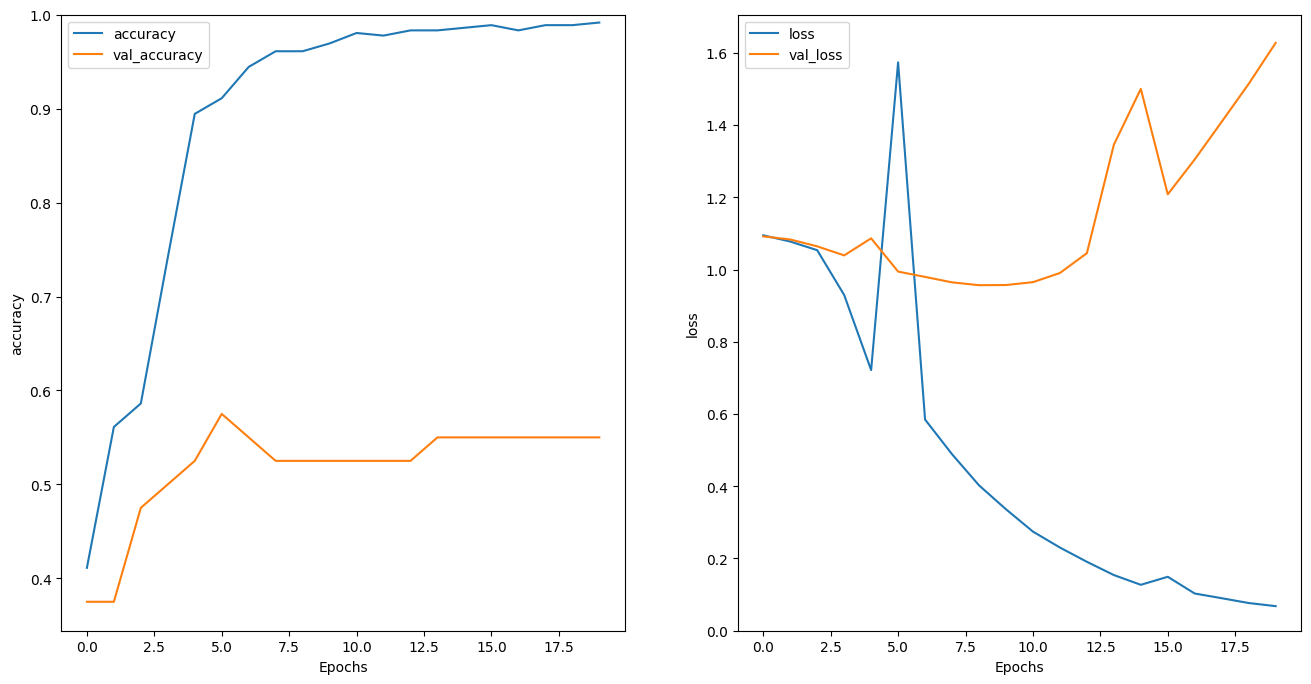

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Peform Inference  
Here the  model is being tested with some text input

In [ ]:
sentence = "i am so sad"
input_seq = tokenizer.texts_to_sequences([sentence])
input_features = pad_sequences(input_seq, maxlen = max_sequence_len, padding = 'post')

#Predict the label
probs = model.predict(input_features)
predicted_y = probs.argmax(axis=-1)
predicted_y
print(encoder.classes_[predicted_y][0])

1/1 [==============================] - 1s 547ms/step
negative


# Save the Model files  
Using MLEM package to save the model files for deployment

##### Save The Tokenizer

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Save the Model

In [ ]:
# Instal mlem for saving the model
# !pip install mlem

In [ ]:
from mlem.api import save,load
save(model, "models/tf")
save(encoder,"encoder/tf")